# KM4 - CT preproccesing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import copy
import SimpleITK as sitk
import os
import skimage
import pydicom
from skimage import morphology
from scipy import ndimage
import cv2

In [2]:
def change_shape(df): 
    new_shape_image = [None] * len(df["image"])

    for i in range(len(df["image"])): 
        img = df["image"][i]
        n = img.shape[2]
        new_img = [None]*n
        for j in range(n):
            new_img[j] = np.flip(img[:,:,j].T)
        new_shape_image[i] = np.array(new_img)
    df["image"] = new_shape_image

def get_data_depth(df, col): 
    return df[col].apply(lambda x: x.shape[0])

# reduces data by cutting CT images
def reduce_depth(df_apply, min_depth): 
    mx = df_apply.shape[0]
    k = np.arange(min_depth)
    k = np.floor((mx/min_depth)*k).astype(int)
   
    return df_apply[k ,:,:]

# the same but using skimage.transform.resize
def reduce_depth_skimage(df, min_depth): 
    return df["image"].apply(lambda x: skimage.transform.resize(x, (512,512,min_depth)))


def normalize(df, col): 
    return (df[col] - df[col].apply(lambda x: np.min(x))) / (df[col].apply(lambda x: np.max(x)) - df[col].apply(lambda x: np.min(x)))

# Load data

## Load mosmed data

W mosmed potrzebujemy zmienić rozmiary naszych danych z `data_mosmed.shape = (512,512,z)` do `data_mosmed.shape = (z,512,512)`. Oprócz tego musimy obrócić zdjęcia obydwu danych były skierowane w tą samą stronę. 

In [3]:
import os
import nibabel as nib

DATA_PATH = "../KM1/mosmed/COVID19_1110/"
MASKS_PATH = "masks/"
STUDIES_PATH = "studies/"

In [4]:
# read all studies nifti data
studies_dirs_list = os.listdir(DATA_PATH+STUDIES_PATH)
studies = {}

n = 2
stud_CT = [None]*(n*5)
stud_images = [None]*(n*5)
stud_name = [None]*(n*5)
j=0

for i_name in range(len(studies_dirs_list)): 
    if (studies_dirs_list[i_name]=='.DS_Store'):
        continue
    dirs_list = os.listdir(DATA_PATH+STUDIES_PATH+studies_dirs_list[i_name])

    for i_im in range(n):
        stud_images[j] = nib.load(DATA_PATH+STUDIES_PATH+studies_dirs_list[i_name]+"/"+dirs_list[i_im])
        stud_CT[j] = studies_dirs_list[i_name]
        stud_name[j] = dirs_list[i_im][:-7]
        j+=1
    

In [5]:
stud_im = [stud_images[i].get_fdata() for i in range(len(stud_images))]
data_mosmed = pd.DataFrame({"Database": "Luna 16", "name": stud_name,  "CT": stud_CT, "image": stud_im})
change_shape(data_mosmed)


In [6]:
data_mosmed.head(5)

,Database,name,CT,image
0,Luna 16,study_0001,CT-0,"[[[-2048.0, -2048.0, -2048.0, -2048.0, -2048.0..."
1,Luna 16,study_0002,CT-0,"[[[-2048.0, -2048.0, -2048.0, -2048.0, -2048.0..."
2,Luna 16,study_0255,CT-1,"[[[-2048.0, -2048.0, -2048.0, -2048.0, -2048.0..."
3,Luna 16,study_0256,CT-1,"[[[-2048.0, -2048.0, -2048.0, -2048.0, -2048.0..."
4,Luna 16,study_0939,CT-2,"[[[-2048.0, -2048.0, -2048.0, -2048.0, -2048.0..."


## Load luna16 data

In [7]:
DATA_ZIP_PATH = "./luna/subset0.zip"
DATA_RAW_FILE = "./luna/subset0/"
ANNOTATIONS_CSV_PATH = "./luna/annotations.csv"
CANDIDATES_CSV_PATH = "./luna/candidates.csv"
CANDIDATES_V2_ZIP_PATH = "./luna/candidates_V2.zip"

In [8]:
dir_list = os.listdir(DATA_RAW_FILE)
images = [None] * 5 
names = [None] * 5
i = 0

while 2*i <  2*5:
    images[i] = sitk.GetArrayFromImage(sitk.ReadImage(DATA_RAW_FILE + dir_list[2*i], sitk.sitkFloat32))
    names[i] = dir_list[2*i][:-4]
    i+=1
    
data_luna = pd.DataFrame({"Database": "Luna 16", "name": names, "CT": "", "image": images})

In [9]:
data_luna.head(5)

,Database,name,CT,image
0,Luna 16,1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031...,,"[[[-3024.0, -3024.0, -3024.0, -3024.0, -3024.0..."
1,Luna 16,1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896...,,"[[[-2048.0, -2048.0, -2048.0, -2048.0, -2048.0..."
2,Luna 16,1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524...,,"[[[-3024.0, -3024.0, -3024.0, -3024.0, -3024.0..."
3,Luna 16,1.3.6.1.4.1.14519.5.2.1.6279.6001.111172165674...,,"[[[-3024.0, -3024.0, -3024.0, -3024.0, -3024.0..."
4,Luna 16,1.3.6.1.4.1.14519.5.2.1.6279.6001.122763913896...,,"[[[-3024.0, -3024.0, -3024.0, -3024.0, -3024.0..."


## Data concatenate

In [10]:
frames = [data_mosmed, data_luna]

data = pd.concat(frames).reset_index()

In [11]:
data["name"]

0                                            study_0001
1                                            study_0002
2                                            study_0255
3                                            study_0256
4                                            study_0939
5                                            study_0940
6                                            study_1064
7                                            study_1065
8                                            study_1109
9                                            study_1110
10    1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031...
11    1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896...
12    1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524...
13    1.3.6.1.4.1.14519.5.2.1.6279.6001.111172165674...
14    1.3.6.1.4.1.14519.5.2.1.6279.6001.122763913896...
Name: name, dtype: object

In [12]:
for i in range(len(data["image"])):
    print(data["image"][i].shape)

(43, 512, 512)
(42, 512, 512)
(38, 512, 512)
(39, 512, 512)
(54, 512, 512)
(43, 512, 512)
(45, 512, 512)
(45, 512, 512)
(36, 512, 512)
(42, 512, 512)
(121, 512, 512)
(119, 512, 512)
(161, 512, 512)
(538, 512, 512)
(124, 512, 512)


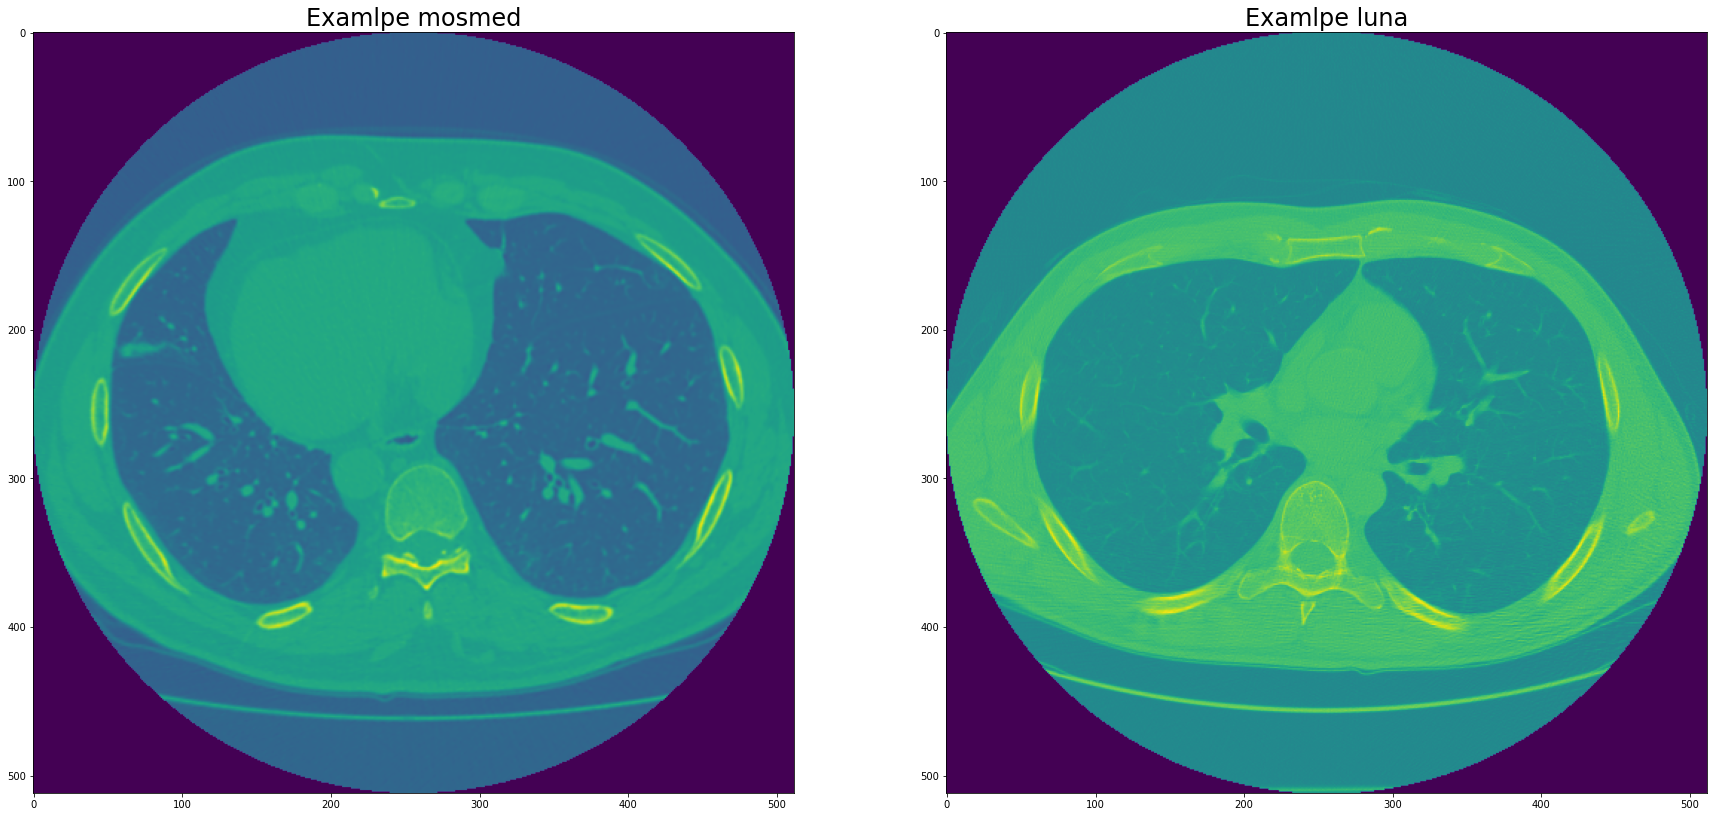

In [13]:
to_draw_mosmed = data_mosmed["image"][0]
to_draw_luna = data_luna["image"][0]


plt.figure(figsize=(1, 1)) 
ax = plt.subplot(1,2,1)
plt.imshow(to_draw_mosmed[15,:,:])
plt.gcf().set_size_inches(30, 30)
ax.set_title("Examlpe mosmed", fontsize=24)

ax = plt.subplot(1,2,2)
plt.imshow(to_draw_luna[60,:,:])
plt.gcf().set_size_inches(30, 30)
ax.set_title("Examlpe luna", fontsize=24)


plt.show()

# Preprocessing

## Reducing depth
W naszych danych mieliśmy duże rozbieżności w wartościach danych. W bazie mosmed głębokość wynosiła około 30-70, a w danych luna 16 wynosiła ona od ok. 100 do nawet 800. Aby sprowadzić nasze dane do wspólnej wielkości postanowiliśmy zmniejszyć nasze dane do najmniejszego wymiaru. Usuwamy przez to dużo danych, ale jest to również bardzo potrzebne, aby zredukować ogromną ilość danych, która zdecydowanie przedłużałaby dalsze obliczenia przy tworzeniu modelu. Równocześnie kolejne zdjęcia sa bardzo podobne, więc nie powinno to wpływać negatywnie na działanie tworzonych w przyszlości modeli. Nasza długość i szerokość w obydwu bazach jest identyczna, więc ich nie zmieniamy. 

In [14]:
min_depth = np.min(get_data_depth(data,"image"))
data["image"] = data["image"].apply(lambda x: reduce_depth(x, min_depth))
for i in range(len(data["image"])):
    print(data["image"][i].shape)

(36, 512, 512)
(36, 512, 512)
(36, 512, 512)
(36, 512, 512)
(36, 512, 512)
(36, 512, 512)
(36, 512, 512)
(36, 512, 512)
(36, 512, 512)
(36, 512, 512)
(36, 512, 512)
(36, 512, 512)
(36, 512, 512)
(36, 512, 512)
(36, 512, 512)


## Remove noise

Usuwamy niepotrzebny szum w naszych zdjęciach.

https://vincentblog.xyz/posts/medical-images-in-python-computed-tomography

In [15]:
def transform_to_hu( image):
    intercept = -1024
    slope = 1
    hu_image = image * slope + intercept

    return hu_image
def window_image(image, window_center, window_width):
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    window_image = image.copy()
    window_image[window_image < img_min] = img_min
    window_image[window_image > img_max] = img_max
    
    return window_image


def remove_noise(image, window_a, window_b, display=False):
    #image = medical_image.pixel_array
    df_img = [None]*len(image)
    for i in range(len(image)): 
        #hu_image = image
        #hu_image = transform_to_hu( image)
        brain_image = window_image(image[i], window_a, window_b) #bone windowing

        segmentation = morphology.dilation(brain_image, np.ones((1, 1)))
        labels, label_nb = ndimage.label(segmentation)

        label_count = np.bincount(labels.ravel().astype(np.int))
        label_count[0] = 0

        mask = labels == label_count.argmax()

        mask = morphology.dilation(mask, np.ones((1, 1)))
        mask = ndimage.morphology.binary_fill_holes(mask)
        mask = morphology.dilation(mask, np.ones((3, 3)))
        df_img[i] = mask * brain_image
    return np.array(df_img)

In [47]:
data["preprocessed_image"] = data["image"].apply(lambda x: remove_noise(x, 0, 1900))

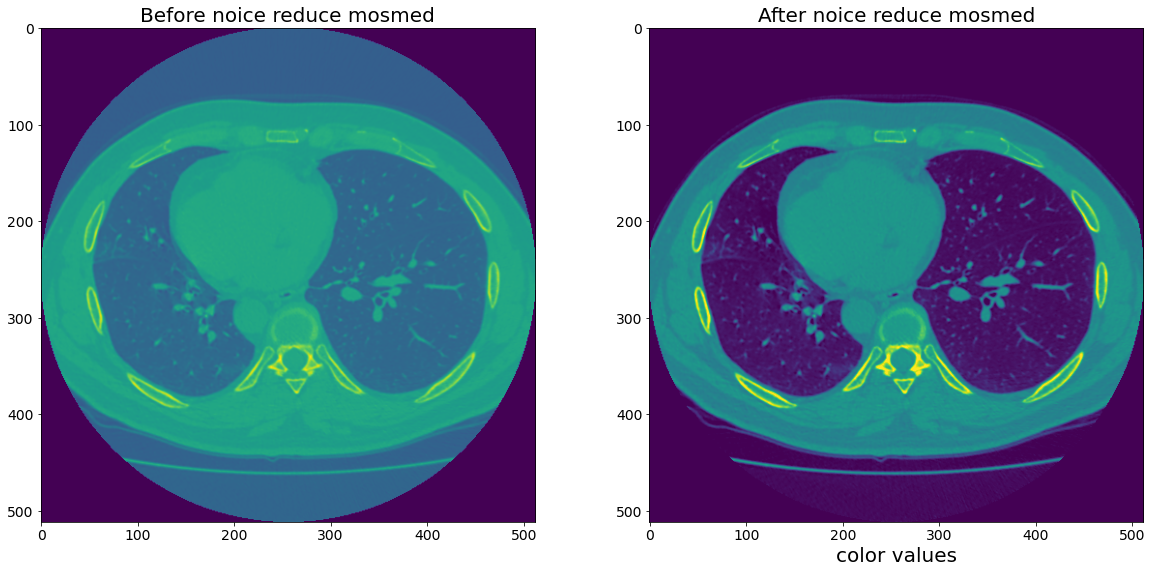

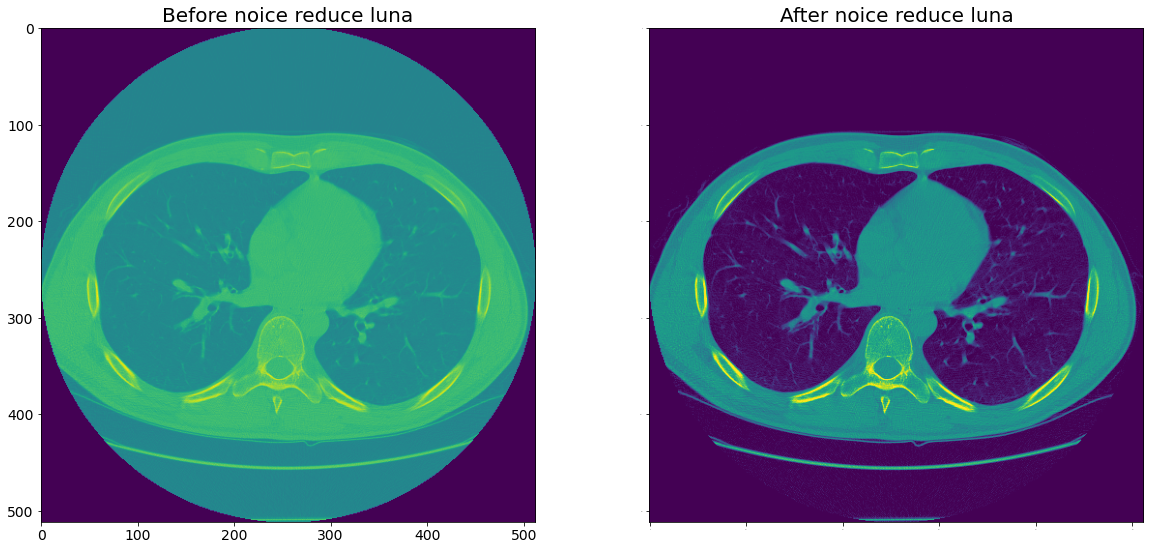

In [48]:
to_draw_mosmed = data["image"][0]
to_draw_mosmed_norm = data["preprocessed_image"][0]
to_draw_luna = data["image"][10]
to_draw_luna_norm = data["preprocessed_image"][10]



plt.figure(figsize=(1, 1)) 
ax = plt.subplot(2,2,1)
plt.imshow(to_draw_mosmed[15,:,:])
plt.gcf().set_size_inches(20, 20)
ax.set_title("Before noice reduce mosmed", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=14)

ax = plt.subplot(2,2,2)
plt.imshow(to_draw_mosmed_norm[15,:,:])
plt.gcf().set_size_inches(20, 20)
ax.set_title("After noice reduce mosmed", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_xlabel("color values", fontsize=20)

plt.figure(figsize=(1, 1)) 
ax = plt.subplot(2,2,3)
plt.imshow(to_draw_luna[15,:,:])
plt.gcf().set_size_inches(20, 20)
ax.set_title("Before noice reduce luna", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=14)

ax = plt.subplot(2,2,4)
plt.imshow(to_draw_luna_norm[15,:,:])
plt.gcf().set_size_inches(20, 20)
ax.set_title("After noice reduce luna", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=1)



plt.show()


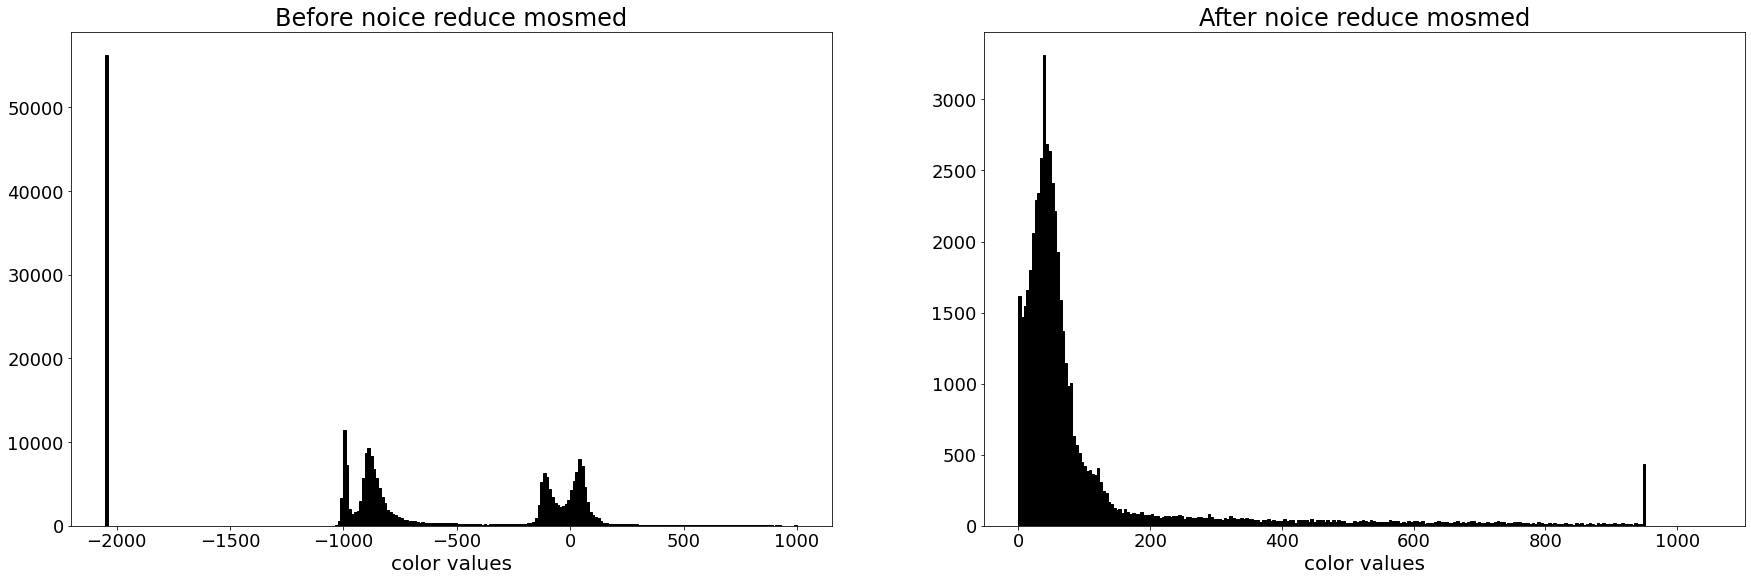

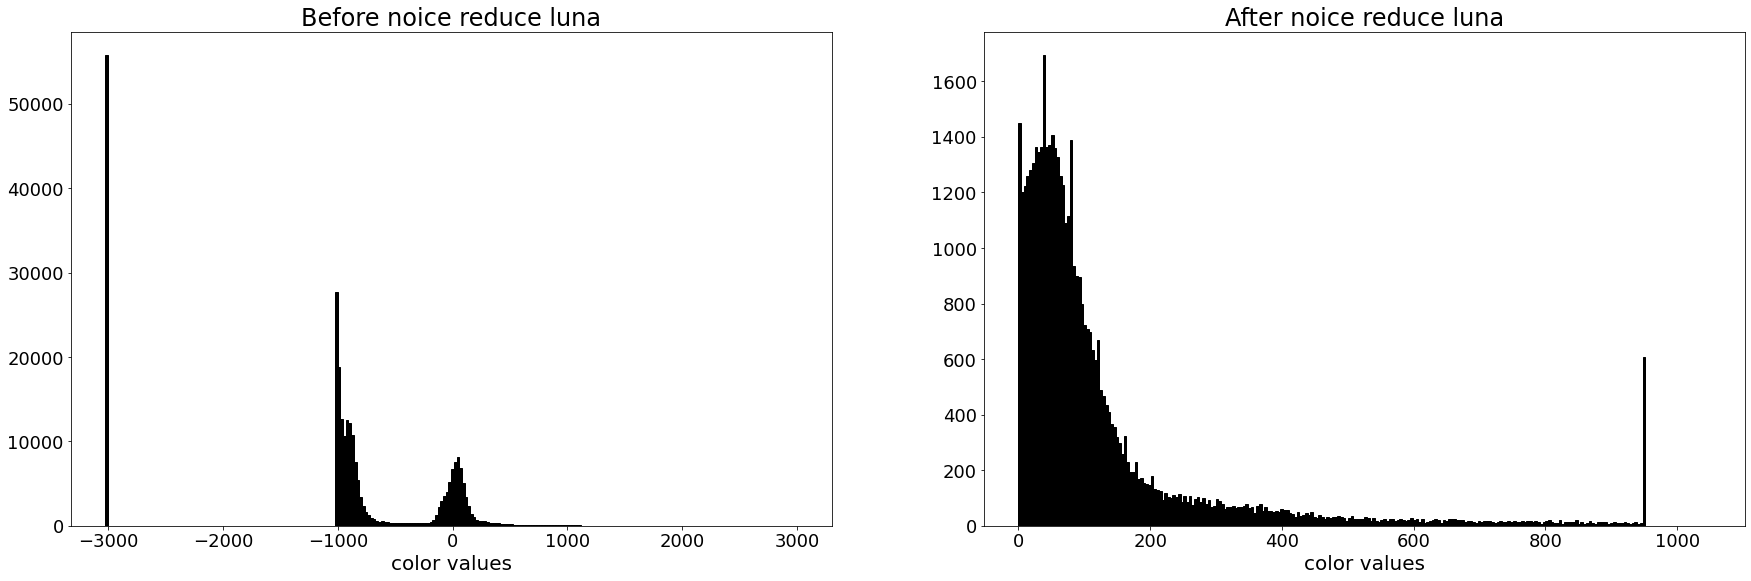

In [49]:
to_draw_mosmed = data["image"][0]
to_draw_mosmed_norm = data["preprocessed_image"][0]
to_draw_luna = data["image"][10]
to_draw_luna_norm = data["preprocessed_image"][10]

plt.figure(figsize=(1, 1)) 
ax = plt.subplot(2,2,1)
plt.hist(to_draw_mosmed[15,:,:].ravel(), range=(-2050.0, 1000.0),bins=256, fc='k', ec='k')
plt.gcf().set_size_inches(30, 20)
ax.set_title("Before noice reduce mosmed", fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.set_xlabel("color values", fontsize=20)

ax = plt.subplot(2,2,2)
plt.hist(to_draw_mosmed_norm[15,:,:].ravel(), range=(0.0, 1050.0),bins=256, fc='k', ec='k')
plt.gcf().set_size_inches(30, 20)
ax.set_title("After noice reduce mosmed", fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.set_xlabel("color values", fontsize=20)

plt.figure(figsize=(1, 1)) 
ax = plt.subplot(2,2,3)
plt.hist(to_draw_luna[15,:,:].ravel(), range=(-3025.0, 3000.0),bins=256, fc='k', ec='k')
plt.gcf().set_size_inches(30, 20)
ax.set_title("Before noice reduce luna", fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.set_xlabel("color values", fontsize=20)

ax = plt.subplot(2,2,4)
plt.hist(to_draw_luna_norm[15,:,:].ravel(), range=(0.0, 1050.0),bins=256, fc='k', ec='k')
plt.gcf().set_size_inches(30, 20)
ax.set_title("After noice reduce luna", fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.set_xlabel("color values", fontsize=20)



plt.show()


# Normalize colors

Na koniec normalizujemy dane poprzez Min-Max normalization do wartości z przedziału [0,1]

In [50]:
data["preprocessed_image"] = normalize(data, "preprocessed_image")

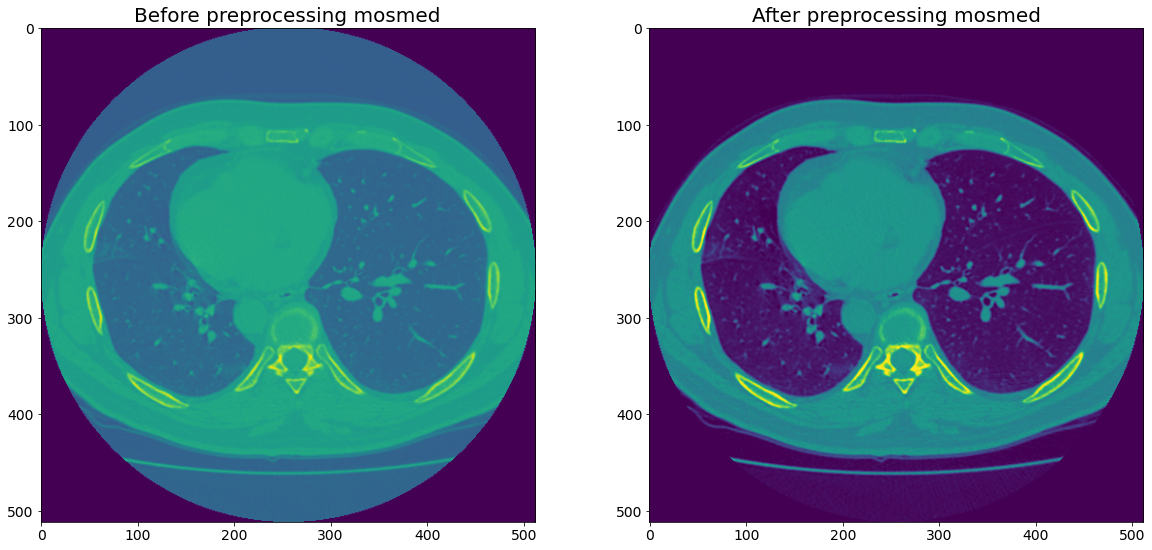

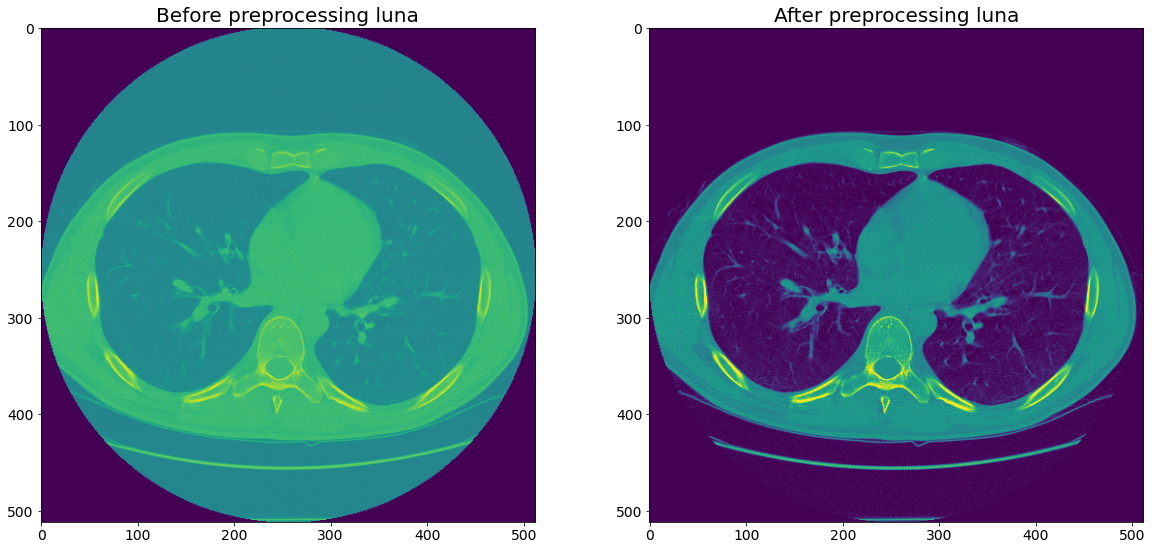

In [51]:
to_draw_mosmed = data["image"][0]
to_draw_mosmed_norm = data["preprocessed_image"][0]
to_draw_luna = data["image"][10]
to_draw_luna_norm = data["preprocessed_image"][10]



plt.figure(figsize=(1, 1)) 
ax = plt.subplot(2,2,1)
plt.imshow(to_draw_mosmed[15,:,:])
plt.gcf().set_size_inches(20, 20)
ax.set_title("Before preprocessing mosmed", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=14)

ax = plt.subplot(2,2,2)
plt.imshow(to_draw_mosmed_norm[15,:,:])
plt.gcf().set_size_inches(20, 20)
ax.set_title("After preprocessing mosmed", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=14)

plt.figure(figsize=(1, 1)) 
ax = plt.subplot(2,2,3)
plt.imshow(to_draw_luna[15,:,:])
plt.gcf().set_size_inches(20, 20)
ax.set_title("Before preprocessing luna", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=14)

ax = plt.subplot(2,2,4)
plt.imshow(to_draw_luna_norm[15,:,:])
plt.gcf().set_size_inches(20, 20)
ax.set_title("After preprocessing luna", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=14)



plt.show()

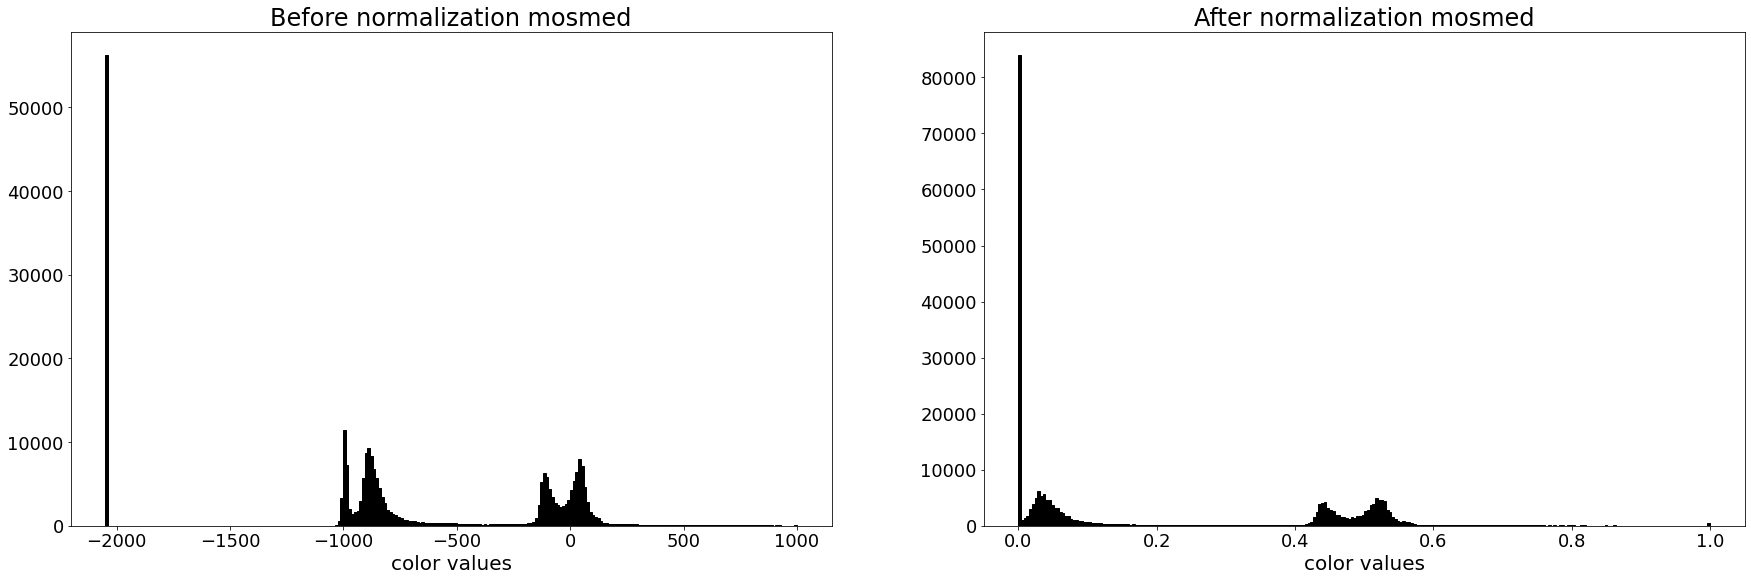

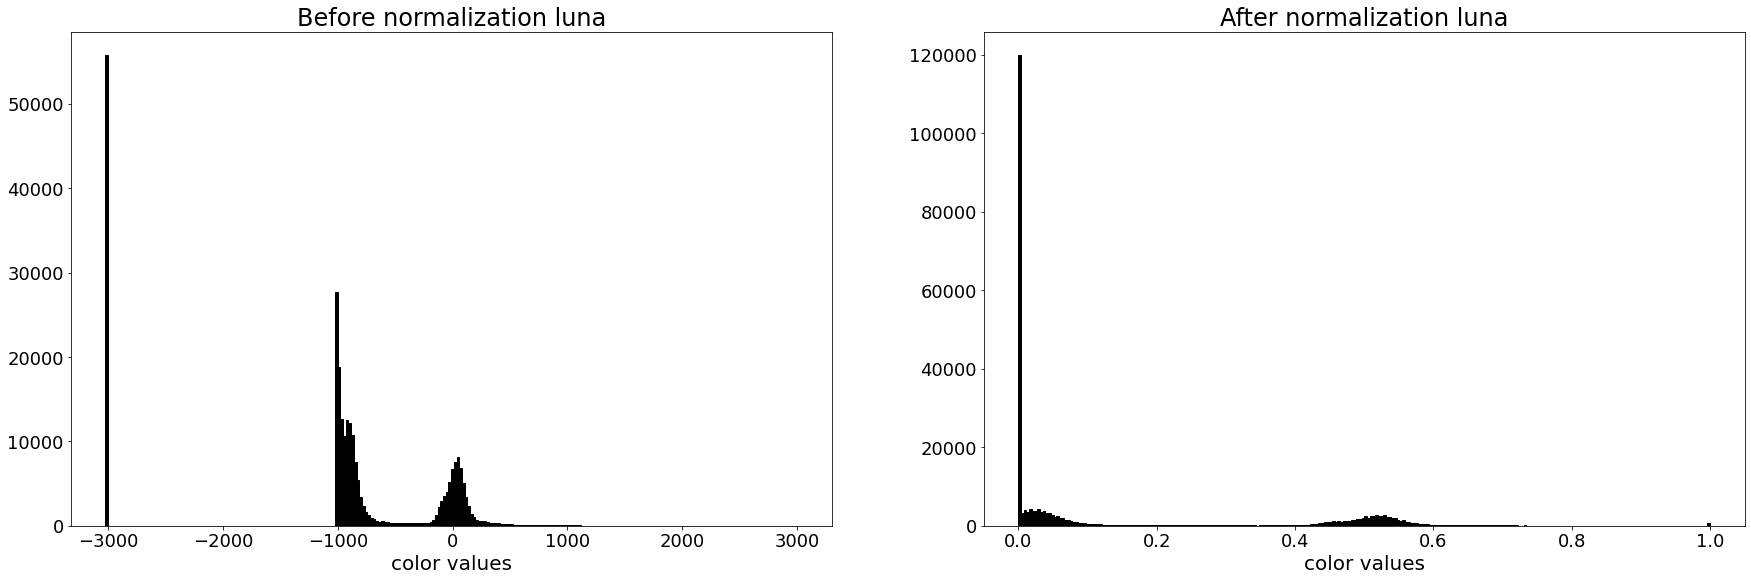

In [52]:
to_draw_mosmed = data["image"][0]
to_draw_mosmed_norm = data["preprocessed_image"][0]
to_draw_luna = data["image"][10]
to_draw_luna_norm = data["preprocessed_image"][10]

plt.figure(figsize=(1, 1)) 
ax = plt.subplot(2,2,1)
plt.hist(to_draw_mosmed[15,:,:].ravel(), range=(-2050.0, 1000.0),bins=256, fc='k', ec='k')
plt.gcf().set_size_inches(30, 20)
ax.set_title("Before normalization mosmed", fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.set_xlabel("color values", fontsize=20)

ax = plt.subplot(2,2,2)
plt.hist(to_draw_mosmed_norm[15,:,:].ravel(), range=(0,1),bins=256, fc='k', ec='k')
plt.gcf().set_size_inches(30, 20)
ax.set_title("After normalization mosmed", fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.set_xlabel("color values", fontsize=20)

plt.figure(figsize=(1, 1)) 
ax = plt.subplot(2,2,3)
plt.hist(to_draw_luna[15,:,:].ravel(), range=(-3025.0, 3000.0),bins=256, fc='k', ec='k')
plt.gcf().set_size_inches(30, 20)
ax.set_title("Before normalization luna", fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.set_xlabel("color values", fontsize=20)

ax = plt.subplot(2,2,4)
plt.hist(to_draw_luna_norm[15,:,:].ravel(), range=(0,1),bins=256, fc='k', ec='k')
plt.gcf().set_size_inches(30, 20)
ax.set_title("After normalization luna", fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.set_xlabel("color values", fontsize=20)



plt.show()

